# How do the original feature set perform with indicators of poverty other than '% Enrolled in Free or Reduced Lunch'?

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import shap

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/hospitalization_data.csv', dtype={'FIPS': object})
data.head()

,FIPS,Hospitalizations,Cases,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Hospitalization Rate,Case Rate,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,12041,80,1588,Florida,Gilchrist,8968.375038,21.126757,4.763684,4.847069,7.669173,...,9.381368,3.4,52.053416,7.608085,52.605415,13.496566,438.2,8698.5,0,1521
1,12107,566,6374,Florida,Putnam,12710.036010,24.952601,5.359802,4.937745,10.439560,...,7.827534,4.3,55.123245,10.481016,52.040792,10.449204,763.2,8594.6,1,1766
2,12123,97,2710,Florida,Taylor,10593.946360,23.831961,4.855759,4.745002,9.772588,...,5.633540,3.6,54.561016,9.412498,60.553383,6.022409,448.6,12533.0,1,1201
3,12091,729,20298,Florida,Okaloosa,8033.687940,15.266246,3.889858,3.875538,7.872828,...,19.608361,2.7,40.581558,17.700785,39.062417,11.659616,351.7,9793.1,0,836
4,12013,59,1686,Florida,Calhoun,10649.098250,24.278851,4.887984,4.772105,8.024691,...,7.022045,4.1,58.913803,8.432470,56.585692,11.858775,404.5,11558.2,0,1621


In [3]:
X = data.drop(["FIPS", "Hospitalizations", "Cases", "Hospitalization Rate", "State", "County"], axis=1)
y = pd.DataFrame(data["Hospitalization Rate"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
len(X.columns)

97

## MLP: Original Features + '% Below Poverty'

In [22]:
X_train_o3 = X_train.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Below Poverty'])

X_val_o3 = X_val.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Below Poverty'])

X_test_o3 = X_test.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Below Poverty'])

In [24]:
"""
Loading custom dataset into Tensors
https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
"""
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.tensor(X.values).float()
        if not torch.is_tensor(y):
            self.y = torch.tensor(y.values).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
train_data_o3 = PrepareData(X_train_o3, y_train)
val_data_o3 = PrepareData(X_val_o3, y_val)
test_data_o3 = PrepareData(X_test_o3, y_test)

In [26]:
batch_size = 8

In [27]:
train_loader_o3 = DataLoader(train_data_o3, 
                          batch_size)

valid_loader_o3 = DataLoader(val_data_o3, 
                          batch_size)

test_loader_o3 = DataLoader(test_data_o3, 
                         batch_size)

In [28]:
class MLP(nn.Module):
    def __init__(self, input_dim=9, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Input
        -----
        x: tensor (batch size x important variable size)
        
        Output
        ------
        predicted values of Hosp rate
            tensor(batch size x 1)
        """
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

In [43]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [44]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o3:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o3:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_org3.model')

Epoch: 1 	Training Loss: 509.669675 	Validation Loss: 539.054776
Epoch: 2 	Training Loss: 494.345539 	Validation Loss: 558.178184
Epoch: 3 	Training Loss: 479.562301 	Validation Loss: 573.088978
Epoch: 4 	Training Loss: 466.174729 	Validation Loss: 577.294891
Epoch: 5 	Training Loss: 441.826604 	Validation Loss: 563.316377
Epoch: 6 	Training Loss: 420.514000 	Validation Loss: 526.737693
Epoch: 7 	Training Loss: 387.705956 	Validation Loss: 467.106777
Epoch: 8 	Training Loss: 336.996636 	Validation Loss: 403.065438
Epoch: 9 	Training Loss: 311.746719 	Validation Loss: 361.467859
Epoch: 10 	Training Loss: 298.183629 	Validation Loss: 343.427715
Epoch: 11 	Training Loss: 285.077702 	Validation Loss: 325.401932
Epoch: 12 	Training Loss: 279.324385 	Validation Loss: 312.529376
Epoch: 13 	Training Loss: 276.934732 	Validation Loss: 304.799570
Epoch: 14 	Training Loss: 265.991170 	Validation Loss: 299.677389
Epoch: 15 	Training Loss: 283.420573 	Validation Loss: 298.699883
Epoch: 16 	Training

In [45]:
best_val_loss

236.3973582874645

In [46]:
mlp.load_state_dict(torch.load('mlp_org3.model'))

In [47]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o3:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o3)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 221.682155



### Explain output through SHAP

In [48]:
mlp = MLP(input_dim=9)
mlp.load_state_dict(torch.load('mlp_org2.model'))

In [50]:
x_o3, _ = next(iter(train_loader_o3))

In [52]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o3)

shap_values = explainer_shap.shap_values(X=x_o3,
                                      ranked_outputs=True)

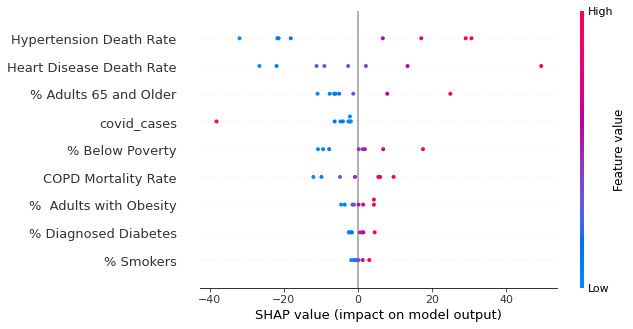

In [54]:
shap.summary_plot(shap_values, x_o3, feature_names=X_train_o3.columns)

## MLP: Original Features + 'Unemployment Rate'

In [56]:
X_train_o4 = X_train.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', 'Unemployment Rate'])

X_val_o4 = X_val.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', 'Unemployment Rate'])

X_test_o4 = X_test.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', 'Unemployment Rate'])

In [57]:
train_data_o4 = PrepareData(X_train_o4, y_train)
val_data_o4 = PrepareData(X_val_o4, y_val)
test_data_o4 = PrepareData(X_test_o4, y_test)

In [58]:
train_loader_o4 = DataLoader(train_data_o4, 
                          batch_size)

valid_loader_o4 = DataLoader(val_data_o4, 
                          batch_size)

test_loader_o4 = DataLoader(test_data_o4, 
                         batch_size)

In [76]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [77]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o4:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o4:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_org4.model')

Epoch: 1 	Training Loss: 499.043123 	Validation Loss: 515.885961
Epoch: 2 	Training Loss: 473.249419 	Validation Loss: 520.495863
Epoch: 3 	Training Loss: 460.445468 	Validation Loss: 502.922996
Epoch: 4 	Training Loss: 426.297650 	Validation Loss: 481.780864
Epoch: 5 	Training Loss: 408.794210 	Validation Loss: 437.327383
Epoch: 6 	Training Loss: 396.480483 	Validation Loss: 399.351325
Epoch: 7 	Training Loss: 322.202514 	Validation Loss: 341.145791
Epoch: 8 	Training Loss: 288.139704 	Validation Loss: 279.365225
Epoch: 9 	Training Loss: 277.512042 	Validation Loss: 247.809099
Epoch: 10 	Training Loss: 295.359518 	Validation Loss: 249.055172
Epoch: 11 	Training Loss: 290.608835 	Validation Loss: 248.877762
Epoch: 12 	Training Loss: 277.603253 	Validation Loss: 251.251008
Epoch: 13 	Training Loss: 262.462092 	Validation Loss: 250.055477
Epoch: 14 	Training Loss: 266.873007 	Validation Loss: 249.136529
Epoch: 15 	Training Loss: 263.382224 	Validation Loss: 249.725364
Epoch: 16 	Training

In [78]:
best_val_loss

240.8931121826172

In [79]:
mlp.load_state_dict(torch.load('mlp_org4.model'))

In [81]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o3:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o3)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 231.944169



### Explain output through SHAP

In [84]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_org4.model'))

In [85]:
x_o4, _ = next(iter(train_loader_o4))

In [87]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o4)

shap_values = explainer_shap.shap_values(X=x_o4,
                                      ranked_outputs=True)

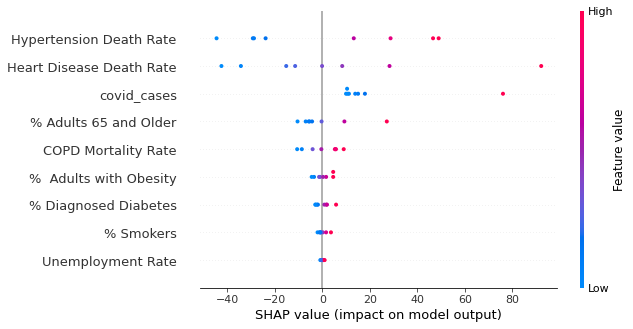

In [88]:
shap.summary_plot(shap_values, x_o4, feature_names=X_train_o4.columns)

## MLP: Original Features + '% Children in Poverty'

In [89]:
X_train_o5 = X_train.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Children in Poverty'])

X_val_o5 = X_val.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Children in Poverty'])

X_test_o5 = X_test.filter(['covid_cases', '% Adults 65 and Older', '% Diagnosed Diabetes',
                '%  Adults with Obesity', 'Heart Disease Death Rate', 'Hypertension Death Rate',
                'COPD Mortality Rate', '% Smokers', '% Children in Poverty'])

In [90]:
train_data_o5 = PrepareData(X_train_o5, y_train)
val_data_o5 = PrepareData(X_val_o5, y_val)
test_data_o5 = PrepareData(X_test_o5, y_test)

In [91]:
train_loader_o5 = DataLoader(train_data_o5, 
                          batch_size)

valid_loader_o5 = DataLoader(val_data_o5, 
                          batch_size)

test_loader_o5 = DataLoader(test_data_o5, 
                         batch_size)

In [116]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [117]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o5:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o5:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_org5.model')

Epoch: 1 	Training Loss: 508.986541 	Validation Loss: 563.816245
Epoch: 2 	Training Loss: 503.293191 	Validation Loss: 582.240945
Epoch: 3 	Training Loss: 497.216287 	Validation Loss: 584.584084
Epoch: 4 	Training Loss: 495.009492 	Validation Loss: 586.064314
Epoch: 5 	Training Loss: 482.034140 	Validation Loss: 596.510517
Epoch: 6 	Training Loss: 486.868134 	Validation Loss: 597.986037
Epoch: 7 	Training Loss: 468.417065 	Validation Loss: 602.306904
Epoch: 8 	Training Loss: 466.998389 	Validation Loss: 595.877699
Epoch: 9 	Training Loss: 426.716385 	Validation Loss: 611.756839
Epoch: 10 	Training Loss: 445.651740 	Validation Loss: 579.311437
Epoch: 11 	Training Loss: 399.457294 	Validation Loss: 565.143159
Epoch: 12 	Training Loss: 378.982544 	Validation Loss: 540.724583
Epoch: 13 	Training Loss: 381.485250 	Validation Loss: 469.027894
Epoch: 14 	Training Loss: 355.048199 	Validation Loss: 410.901086
Epoch: 15 	Training Loss: 323.285747 	Validation Loss: 380.149242
Epoch: 16 	Training

In [118]:
best_val_loss

235.60653547807172

In [119]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o5:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o5)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 229.552747



### Explain output through SHAP

In [120]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_org5.model'))

In [121]:
x_o5, _ = next(iter(train_loader_o5))

In [122]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o5)

shap_values = explainer_shap.shap_values(X=x_o5,
                                      ranked_outputs=True)

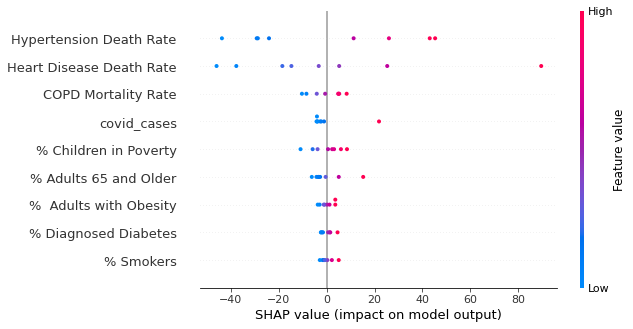

In [123]:
shap.summary_plot(shap_values, x_o5, feature_names=X_train_o5.columns)